## Superresolution




note: there are the following domains:
- spatial domain
- spatial frequency domain
- temporal domain
- temporal frequency domain

The image $i(x,y)$ is formed by filtering the object function $o(x,y)$ with a filter $T(\omega_x,\omega_y)$ in the spatial frequency domain. This is equivalent to a convolution in the spatial domain.

\begin{align}
I(\omega_x,\omega_y) &= T(\omega_x,\omega_y) \cdot O(\omega_x,\omega_y) \\
i(x,y) &= t(x,y) \circledast o(x,y) \\
i(x,y) &= \iint_{-\infty}^{\infty} i(x-x',y-y') \cdot o(x',y') dx'dy'
\end{align}


The filter $T(\omega_x,\omega_y)$ limits the observable high frequencies and also blurs the image points by diffraction. With the assumption, that the function $O(\omega_x,\omega_y)$ is band limited <p style="color:red"> there exist a unique solution to extrapolate $i(\omega_x,\omega_y)$ outside the band limit in absence of noise. (see next paragraph) </p>

## Deconvolution
in the spatial frequency domain

\begin{align}
I(\omega_x,\omega_y) = \frac{O(\omega_x,\omega_y)}{T(\omega_x,\omega_y) + k }
\end{align}

with element-wise division and an additional konstant $k$ to counteract noise.

never the less there are instabilities when dividing by zero or in presence of noise in $o(x,y)$, or even by noise after fft.

In [22]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

#import image
BGR_pic = cv2.imread('./pics/cameraman.png')
pic = cv2.cvtColor(BGR_pic, cv2.COLOR_BGR2RGB)
bw_pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)

from skimage.transform import rescale
bw_pic = rescale(bw_pic, 0.5, anti_aliasing=True)

bw_pic.shape

(256, 256)

In [23]:
def fourier_convolution(A,B):
    print('implemented convolution. differences at the edges are possible !!!')
    dimA = np.shape(A)
    dimB = np.shape(B)
    #next power of two => efficient fft and automatic zero padding
    #size = 2**np.ceil(np.log2(dimA)).astype(int)
    #fft trafo image
    aa = np.fft.fft2(A)
    #fft trafo kernel
    bb = np.fft.fft2(B, dimA)
    #multiply in fourier space
    cc = np.multiply( aa , bb )
    #reverse fft trafo
    C = np.fft.ifft2( cc )
    return C
def reverse_convolution(A,B):
    print('reverse convolution by division with filter in fourier space.')
    dimA = np.shape(A)
    dimB = np.shape(B)
    #fft trafo image
    aa = np.fft.fft2(A)
    #fft trafo kernel
    bb = np.fft.fft2(B, dimA)
    #divide in fourier space
    cc = np.divide( aa , bb )
    
    #keep small values at zero for numerical stability when dividing by zero
    mask = np.logical_and( np.abs(aa)>1e-22 , np.abs(bb)>1e-16 )
    cc = np.multiply( cc , mask)
    
    #reverse fft trafo
    C = np.fft.ifft2( cc )
    return C

In [24]:
#superresolution by division with convolution filter in fourier space
box = np.ones((9,9))
box = box * 1/np.sum(box)
boxBlur = np.real( fourier_convolution(bw_pic,box) )
superres = reverse_convolution(boxBlur,box)

implemented convolution. differences at the edges are possible !!!
reverse convolution by division with filter in fourier space.


(-0.5, 255.5, 255.5, -0.5)

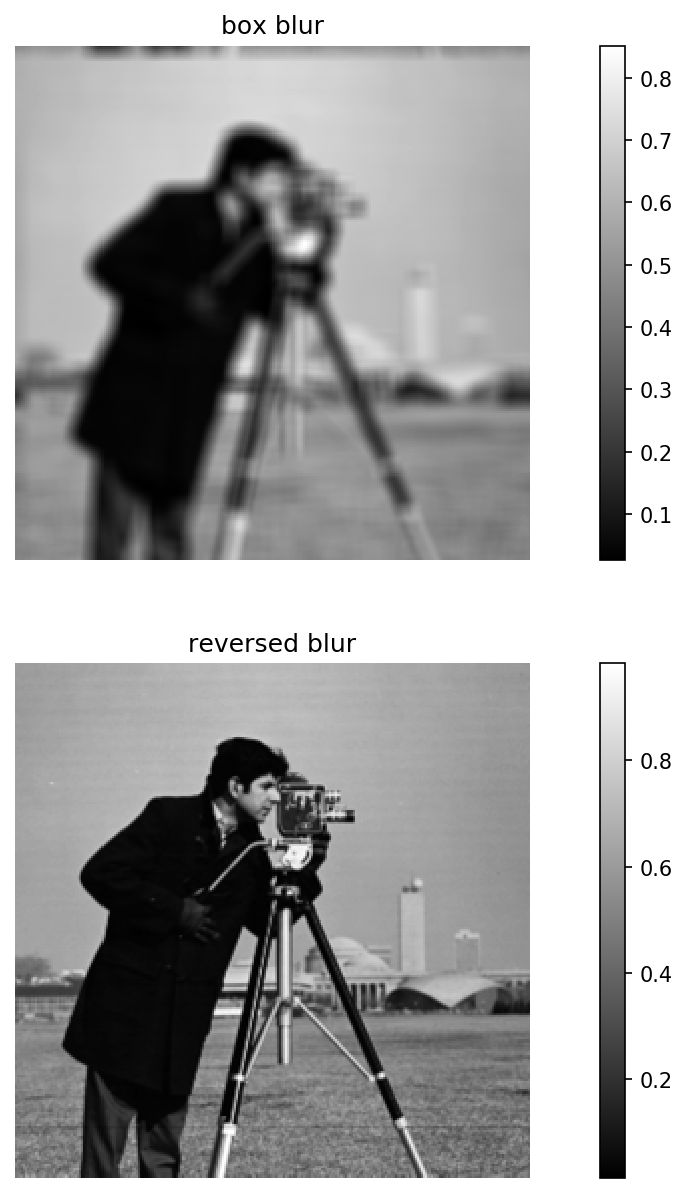

In [25]:
#plot filter
fig = plt.figure(figsize=(12,10), dpi=150)

plt.subplot(2,1,1)
plt.imshow(np.real(boxBlur), cmap='gray')
plt.colorbar()
plt.title('box blur')
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(np.real(superres), cmap='gray')
plt.colorbar()
plt.title('reversed blur')
plt.axis('off')

## Maximum-Likelihood Expectation-Maximization (Richardson–Lucy)

formulating the probability for an underlaying image $o(x,y)$ with bayes theorem for every ideal pixel $o_i$ and measured pixel $i_k$ with distance $|k-i|$ between them:

\begin{align}
P(o_i|i_k) &= \frac{P(i_k|o_i) P(o_i)}{P(i_k)} \\
&= \frac{P(i_k|o_i) P(o_i)}{\sum_j P(i_k|o_j) P(o_j)}
\end{align}

with

\begin{align}
P(o_i) &= \sum_k P(o_i|i_k) P(i_k)
\end{align}

follows

\begin{align}
P(o_i) &= P(o_i) \sum_k \frac{P(i_k|o_i) P(i_k)}{\sum_j P(i_k|o_j) P(o_j)}
\end{align}

We also assume an equal distribution for all possible values of $o_i$, $i_k$ and the PSF $t_{i,k}$ with the number of values $N(i)$, so that

\begin{align}
P(o_i) &= \frac{o_i}{N(o)} \\
P(i_k) &= \frac{i_k}{N(i)} \\
P(o_k|i_i) &= P(t_{i,k}) = \frac{t_{i,k}}{N(t_{i,k})}
\end{align}

Since $o_j$ isn't known, we start with 1 and approximate it afterwards from the previous iteration $r$.
as a result we get our algorithm

\begin{align}
o_i^{r+1} &= o_i^r \sum_k \frac{t_{i,k} i_k}{\sum_j t_{j,k} o_j^r}\\
&= o^r \cdot \bigg( t \circledast \frac{i}{t \circledast o^r} \bigg)
\end{align}

with element-wise division and multiplication

## Richardson–Lucy

high level description, with convolutions in fourier space.

known: $I(x,y)$,$T(\omega_x,\omega_y)$ <br>
guess: $o^0(x,y)$ (usually uniform intensity) <br>
loop: <br>
- $o^k(x,y) -> O^k(\omega_x,\omega_y)$
- $I^k(\omega_x,\omega_y) = T(\omega_x,\omega_y) \cdot O^k(\omega_x,\omega_y)$
- $I(\omega_x,\omega_y) -> i^k(x,y)$
- $h^k(x,y) = \frac{i(x,y)}{i^k(x,y)}$
- $h^k(x,y) -> H^k(\omega_x,\omega_y)$
- $G^k(\omega_x,\omega_y) = T(\omega_x,\omega_y) \cdot H^k(\omega_x,\omega_y)$
- $G^k(\omega_x,\omega_y) -> g^k(x,y)$
- $o^{(r+1)} = o^r(x,y) \cdot g^r(x,y)$

untill convergence<br>

note: image bandlimit is limited by initial guess $o^0(x,y)$. Also after each iteration one has to set negativ pixels to zero.

## Structured illumination

illumination with sine function:

\begin{align}
I(r) & =I_0 [1 + m \cdot cos(k_s r + \phi)] \\
&=I_0 \big[ 1 + \frac{m}{2} e^{i k_s r} e^{i \phi} + \frac{m}{2} e^{- i k_s r} e^{- i \phi} \big]
\end{align}

light on detector $D$ is modulated with $I$ and blurred by PSF $H$ including noise $N$ wich results in:

\begin{align}
D(r) &= [S \cdot I] \circledast H + N\\
D(k) &= \frac{I_0}{2} \bigg[ S(k) + \frac{m}{2} S(k_s-k) e^{i \phi} + \frac{m}{2} S(k_s+k) e^{-i \phi} \bigg] \cdot H + N
\end{align}

So the spectrum is a sum of the signal replicated and shifted 3 times and limited by $H$ afterwards. This means, that not only the low frequencies of the signal get captured, but also shifted high frequencies. By changing $\phi \in [0,60°,120°]$ and decomposing the measurement one can resolve beyond the border of the non shifted signal.

  

## combintation of multiple images

subimages $X_k$ are produced by blurring with $H$ and downsampling (incl. transformations) $D_k$ from a high resolution image $Y$

\begin{align}
X_k = D_k \cdot ( H \cdot Y )
\end{align}

Optimization problem:<br>
find Y that minimizes following cost function

\begin{align}
argmin_Y \sum_k |D_k \cdot ( H \cdot Y ) - X_k|_2^2
\end{align}

or for the underdetermined case

\begin{align}
argmin_Y \sum_k |D_k \cdot ( H \cdot Y ) - X_k|_1 + \lambda |\nabla Y|_1
\end{align}

or alternatively by 

solved with gradient descent



## other methods
- scanning near-field optical microscopy (SNOM) [in the near field high frequencies aren't lost due to diffraction]
- Stimulated Emission Depletion (STED) [fluoroesent dye depleted everywhere, except a small region -> rastering probe with undepleted points]
- Fluorescence polarization microscopy [changing polarization exites molecules at different rotation angles -> nearby molecules with different orientation light up at different polarization angles] (SDOM)
- optical fluctuation imaging microscopy (SOFI) [fluorophores send signals at fluctuating times -> Autocorrelation of Signals determines times and locations, even if multiple signals are sending at the same time.]